#  Import Necessary Libraries

In [ ]:
# Import standard libraries
import numpy as np
import matplotlib.pyplot as plt

# Import Qiskit components
from qiskit import Aer
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import COBYLA, SPSA
from qiskit_algorithms.utils import algorithm_globals
from qiskit.primitives import Estimator

# For reproducibility
algorithm_globals.random_seed = 42

# Explanation

- **numpy, matplotlib**  
  For numerical operations (arrays, linear algebra) and for plotting results such as energy convergence or wave-function profiles.

- **qiskit**  
  The main quantum-computing framework we use to build circuits, run simulations, and perform the VQE algorithm.

- **Aer**  
  Qiskit’s high-performance simulator backend used to execute our quantum circuits locally instead of on real hardware.

- **Parameter, ParameterVector**  
  Qiskit utilities to create symbolic parameters for variational circuits. These parameters are later optimized by the classical optimizer.

- **TwoLocal**  
  A pre-built, hardware-efficient ansatz (variational circuit) composed of alternating single-qubit rotations and entangling layers.

- **SparsePauliOp**  
  Data structure representing a Hamiltonian as a weighted sum of Pauli operators (e.g., `c0 * ZI + c1 * IZ + c2 * ZZ`).  
  This format is efficient for VQE because expectation values of Pauli terms are easy to measure.

- **VQE**  
  Qiskit’s implementation of the Variational Quantum Eigensolver, which iteratively finds the ground-state energy of a Hamiltonian.

- **COBYLA, SPSA**  
  Classical optimizers used in the VQE loop:
  - *COBYLA* is gradient-free and good for small-dimensional problems.
  - *SPSA* is robust to noise and works well on quantum hardware.

- **Estimator**  
  A Qiskit primitive to calculate expectation values  
  \(\langle \psi(\theta) | H | \psi(\theta) \rangle\),  
  which is the quantity minimized during VQE.


## 2. Define the Problem: Harmonic Oscillator Hamiltonian

We want to represent the truncated 1D harmonic-oscillator Hamiltonian

\[
H = a^\dagger a + \tfrac{1}{2}
\]

on **2 qubits**, which lets us encode the first four Fock states  
\(|0\rangle, |1\rangle, |2\rangle, |3\rangle\).

### Number Operator in the Computational Basis
For this truncation the number operator \(a^\dagger a\) is simply

\[
N = \operatorname{diag}([0, 1, 2, 3]).
\]

The full Hamiltonian is therefore
\[
H = N + \tfrac{1}{2} I.
\]

### Mapping to Pauli Operators
Any 2-qubit diagonal matrix can be written as a linear combination of tensor products
of Pauli \(I\) and \(Z\) operators:

\[
\{I\otimes I,\; Z\otimes I,\; I\otimes Z,\; Z\otimes Z\}.
\]

Let’s label the basis states in binary order:

| n | binary | energy |
|---|--------|--------|
| 0 | 00     | 0  +0.5   |
| 1 | 01     | 1    +0.5   |
| 2 | 10     | 2    +0.5   |
| 3 | 11     | 3    +0.5   |

Write the operator as
\[
N = c_0\, I\otimes I + c_1\, Z\otimes I + c_2\, I\otimes Z + c_3\, Z\otimes Z .
\]

For a diagonal Pauli expansion the eigenvalue of \(Z\) is \(+1\) for \(|0\rangle\)  
and \(-1\) for \(|1\rangle\).  
Solving the four linear equations for \(c_0,c_1,c_2,c_3\) yields

\[
\boxed{
N = \tfrac{3}{2}\,I\otimes I
    - \tfrac{1}{2}\,Z\otimes I
    - I\otimes Z
    + \tfrac{1}{2}\,Z\otimes Z
}.
\]

The Hamiltonian is therefore

\[
\boxed{
H = \tfrac{3}{2}\,I\otimes I
    - \tfrac{1}{2}\,Z\otimes I
    - I\otimes Z
    + \tfrac{1}{2}\,Z\otimes Z
    + \tfrac{1}{2}\,I\otimes I
}
\]
which simplifies to
\[
\boxed{
H = 2\,I\otimes I
    - \tfrac{1}{2}\,Z\otimes I
    - I\otimes Z
    + \tfrac{1}{2}\,Z\otimes Z
}.
\]

This Pauli-string form is exactly what we pass to Qiskit as a
`SparsePauliOp` when setting up the VQE.


In [ ]:
# Let's define the Hamiltonian H = a⁺a + 1/2 for a 2-qubit system

# The number operator N = a⁺a has eigenvalues n = [0, 1, 2, 3]
# We can write it using Pauli-Z matrices. The result of this decomposition is:
# a⁺a =  (1.5)*II + (-1.0)*IZ + (-0.5)*ZI + (0.0)*ZZ
# Then we add 1/2 of the identity: H = a⁺a + 1/2*I = (2.0)*II + (-1.0)*IZ + (-0.5)*ZI + (0.0)*ZZ

# Define the Hamiltonian using SparsePauliOp
hamiltonian_ho = SparsePauliOp.from_list([
    ("II", 2.0),   # Constant term
    ("IZ", -1.0),  # Interaction term
    ("ZI", -0.5),  # Interaction term
    ("ZZ", 0.0)    # This term has a coefficient of 0, included for completeness
])

# Print the Hamiltonian
print("Harmonic Oscillator Hamiltonian (Pauli form):")
print(hamiltonian_ho)
print(f"\nClassically calculated exact ground state energy: {0.5}") # E0 = n + 1/2 for n=0

## Explanation

We express the truncated harmonic-oscillator Hamiltonian  
\[
H = a^\dagger a + \tfrac{1}{2}
\]
as a **sum of Pauli terms** acting on two qubits.

- **II**  
  The identity on both qubits.

- **Coefficients**  
  By solving a linear system so that the Pauli expansion reproduces the diagonal matrix  
  \(\operatorname{diag}([0.5,\; 1.5,\; 2.5,\; 3.5])\) (i.e. \(n + 0.5\) for \(n=0,1,2,3\)),  
  we obtain the Hamiltonian
  \[
  H = 2.0\,II - 1.0\,Z\otimes I - 0.5\,I\otimes Z + 0.5\,Z\otimes Z.
  \]

- **Ground-state energy**  
  The lowest eigenvalue of this operator is
  \[
  E_0 = 0.5,
  \]
  which matches the known analytic ground-state energy of the 1-D harmonic oscillator.

This Pauli-string form is what we provide to Qiskit as a `SparsePauliOp` for the VQE algorithm.


# Variational Ansatz Reference

An **ansatz** is the parametrized quantum circuit used to approximate the
ground state \(|\psi(\boldsymbol{\theta})\rangle\).
Its design determines:
- the expressibility of the state space,
- the number of parameters,
- the circuit depth (hardware cost),
- and the ease of optimization.

Below is an overview of the major families of ansätze, their key ideas,
advantages, and when to use them.

---

## 1. Hardware-Efficient Ansatz
**Key idea:** Alternate single-qubit rotations with layers of entangling gates
(CNOT, CZ, etc.), arranged to match the native connectivity of the device.

- **Example in Qiskit:**  
  `TwoLocal` circuit with options for rotation gates (`ry`, `rz`, `rx`) and
  entanglement pattern (`linear`, `full`, `circular`).
- **Pros:**  
  - Shallow depth (good for Noisy Intermediate-Scale Quantum, NISQ, hardware).  
  - Simple to implement and scale.
- **Cons:**  
  - Parameters may be hard to optimize (barren plateaus for deep circuits).  
  - Lacks explicit chemical or physical structure.

---

## 2. Unitary Coupled-Cluster (UCC)
**Key idea:** Inspired by classical coupled-cluster methods in quantum chemistry.
Applies exponentials of excitation operators to a reference (e.g., Hartree–Fock)
state.

- **Variants:**  
  - UCCSD (singles and doubles),  
  - k-fold excitations (UCCGSD, UCC3, …),  
  - Qubit-ADAPT-VQE (adaptive selection of cluster terms).
- **Pros:**  
  - Physically motivated; systematically improvable.  
  - Captures electron correlation accurately.
- **Cons:**  
  - Circuits can become deep; need Trotterization or more advanced exponentiation.

---

## 3. Quantum Alternating Operator Ansatz (QAOA-style)
**Key idea:** Alternate unitaries generated by the **problem Hamiltonian**
and a **mixing Hamiltonian**:
\[
U(\boldsymbol{\gamma},\boldsymbol{\beta})
= \prod_{k=1}^p e^{-i\beta_k H_M} e^{-i\gamma_k H_C}.
\]

- **Use case:**  
  - Discrete combinatorial optimization, MaxCut, portfolio optimization, etc.
- **Pros:**  
  - Parameters often have physical interpretation.  
  - Depth \(p\) controls accuracy.
- **Cons:**  
  - Best for cost Hamiltonians with \(\pm 1\) spectrum.

---

## 4. Problem-Inspired / Chemistry-Inspired Ansatz
**Key idea:** Tailor the circuit to known physical symmetries or
expected form of the ground state.

- **Examples:**  
  - Symmetry-preserving ansatz (conserves particle number, spin, etc.).  
  - Custom Gaussians or squeezed-state generators for harmonic oscillators.  
  - Fermionic Gaussian ansatz (match quadratic fermionic Hamiltonians).
- **Pros:**  
  - Efficient if the physics is well understood.  
  - Fewer parameters if constraints reduce the search space.
- **Cons:**  
  - Requires domain knowledge.

---

## 5. Adaptive Ansatz
**Key idea:** Build the circuit *on the fly* by adding gates/operators that
most reduce the energy at each iteration.

- **Representative methods:**  
  - **ADAPT-VQE** (chemistry): add the operator with the largest energy gradient.  
  - **VAns** or variational circuit growth approaches.
- **Pros:**  
  - Grows only as needed—potentially shallow circuits.  
  - Avoids wasted parameters.
- **Cons:**  
  - Repeated measurements to evaluate gradients can be costly.

---

## 6. Tensor-Network / Matrix-Product-State (MPS) Ansatz
**Key idea:** Mimic classical MPS or PEPS representations.
Use a chain of qubits with nearest-neighbor entanglement.

- **Pros:**  
  - Natural for 1D many-body systems with area-law entanglement.  
  - Parameters scale linearly with system size.
- **Cons:**  
  - Less suitable for highly entangled states beyond area law.

---

## 7. Qubit Excitation-Preserving Ansatz
**Key idea:** Constrain the number of excitations to match a known
particle number or magnetization.

- **Example:** Excitation-preserving gates (e.g., `Rxx`, `Ryy` rotations).
- **Pros:**  
  - Smaller Hilbert space to explore, improved optimization.
- **Cons:**  
  - Requires prior knowledge of the conserved quantity.

---

## 8. Continuous-Variable (CV) Ansatz  *(for photonic platforms)*
**Key idea:** Use Gaussian operations (displacements, squeezers, beamsplitters)
and non-Gaussian gates.

- **Pros:**  
  - Natural for bosonic systems like the harmonic oscillator.
- **Cons:**  
  - Requires a CV hardware model; not native to qubit devices.

---

## 9. Special-Purpose Ansatz
Many research works propose custom ansätze for particular applications:
- **Variational Hamiltonian Ansatz (VHA):**  
  Apply time-evolution unitaries of sub-Hamiltonians with independent parameters.
- **Heuristic entanglers** for specific topologies (ring, star, 2D lattice).
- **Fourier or Chebyshev ansatz** for periodic potentials.

---

### Choosing an Ansatz
- **Hardware limits:** Coherence time, qubit connectivity, gate set.
- **Problem knowledge:** Exploit symmetries, expected correlations.
- **Optimization landscape:** Fewer parameters and constraints
  reduce the chance of barren plateaus.
- **Goal accuracy:** Higher-fidelity results often require deeper or
  more structured ansätze.

> **Rule of thumb:**  
> *Start simple (Hardware-Efficient), then incorporate physics
> (Problem-Inspired or UCC) if the simple circuit cannot reach the desired
> accuracy.*



In [ ]:
# Define a hardware-efficient ansatz using TwoLocal
num_qubits = 2
reps = 2  # Number of times to repeat the entangling layer

# Create the ansatz: Rotations (Ry) + Entangling (CZ) + Rotations (Ry)
ansatz = TwoLocal(num_qubits, rotation_blocks='ry', entanglement_blocks='cz', entanglement='linear', reps=reps)

# Draw the ansatz circuit to see what we built
print("Variational Ansatz Circuit:")
print(ansatz.decompose().draw(output='text')) # .decompose() shows the full circuit

# Get the initial parameters for the optimizer
initial_point = np.random.random(ansatz.num_parameters)
print(f"\nNumber of parameters: {ansatz.num_parameters}")
print(f"Initial parameters: {initial_point}")

## Explanation: TwoLocal Ansatz

- **TwoLocal**  
  Creates a variational ansatz composed of alternating layers of single-qubit rotations and entangling gates.

- **rotation_blocks='ry'**  
  We use Ry rotations because they can generate any single-qubit superposition.

- **entanglement_blocks='cz'**  
  Controlled-Z gates create entanglement between qubits.

- **entanglement='linear'**  
  Qubits are connected in a linear chain (e.g., Q0 ⟷ Q1).

- **reps=2**  
  The pattern of rotations + entanglement is repeated twice.  
  - More repetitions → more expressive circuit  
  - But also harder to optimize (more parameters, possible barren plateaus).

- **Parameters**  
  Each Ry gate has a tunable angle, which the classical optimizer adjusts during VQE to minimize the expectation value of the Hamiltonian.


## 4. Set Up the VQE Algorithm

The **Variational Quantum Eigensolver (VQE)** combines all the components we have prepared:

1. **Hamiltonian** (`SparsePauliOp`)  
   Represents the truncated harmonic-oscillator Hamiltonian as a sum of Pauli strings.

2. **Ansatz** (`TwoLocal`)  
   A parameterized quantum circuit that generates trial states \(|\psi(\boldsymbol{\theta})\rangle\).

3. **Classical Optimizer** (e.g., `COBYLA` or `SPSA`)  
   Adjusts the parameters of the ansatz to minimize the expectation value
   \(\langle \psi(\boldsymbol{\theta}) | H | \psi(\boldsymbol{\theta}) \rangle\).

4. **Backend** (`Aer` simulator)  
   Runs the quantum circuit and returns measurements.

---

### How it works

1. Initialize the parameters \(\boldsymbol{\theta}\) (random or zero).  
2. Prepare the ansatz state \(|\psi(\boldsymbol{\theta})\rangle\).  
3. Measure the expectation value \(\langle H \rangle\) by summing the contributions
   of all Pauli terms.  
4. Feed the result to the classical optimizer to update \(\boldsymbol{\theta}\).  
5. Repeat steps 2–4 until convergence.  

At the end, the VQE outputs:

- The **minimum energy** found (approximating the ground-state energy).  
- The **optimal parameters** \(\boldsymbol{\theta}_\text{opt}\) corresponding to
  the approximate ground-state wavefunction.


In [ ]:
# 1. Choose a classical optimizer
# COBYLA is good for noiseless simulators, SPSA is better for real noisy hardware
optimizer = COBYLA(maxiter=200)  # Limit to 200 iterations

# 2. Choose the backend (quantum simulator)
backend = Aer.get_backend('aer_simulator_statevector')

# 3. Use the Estimator primitive
estimator = Estimator()

# 4. Instantiate the VQE algorithm
vqe = VQE(estimator=estimator,
          ansatz=ansatz,
          optimizer=optimizer,
          initial_point=initial_point)


## Explanation: VQE Components

- **optimizer**  
  The classical algorithm that adjusts the parameters of the ansatz to minimize the energy.  
  - *COBYLA*: gradient-free, robust, and works well in simulation.

- **backend**  
  The quantum simulator or device that executes the quantum circuit.  
  - For example, Qiskit's `Aer` simulator.

- **estimator**  
  Computes the expectation value  
  \(\langle \psi(\boldsymbol{\theta}) | H | \psi(\boldsymbol{\theta}) \rangle\)  
  for a given set of parameters \(\boldsymbol{\theta}\).

- **VQE class**  
  Combines the Hamiltonian, ansatz, optimizer, backend, and estimator into one
  algorithm object ready to run.


# 5. Run the Calculation and Get the Result

In [ ]:
# Run the VQE algorithm
result = vqe.compute_minimum_eigenvalue(hamiltonian_ho)

# Extract the results!
vqe_energy = result.eigenvalue.real
opt_params = result.optimal_parameters
num_evals = result.optimizer_evals

print("\n--- VQE Results ---")
print(f"Calculated ground state energy: {vqe_energy:.6f}")
print(f"Exact ground state energy: {0.5}")
print(f"Error: {abs(vqe_energy - 0.5):.6f}")
print(f"Optimizer evaluations: {num_evals}")
print(f"Optimal parameters: {opt_params}")

## Explanation: Running the VQE

- **`vqe.compute_minimum_eigenvalue(hamiltonian_ho)`**  
  Runs the full hybrid quantum-classical loop.

- **Quantum step:**  
  The simulator prepares the ansatz state \(|\psi(\boldsymbol{\theta})\rangle\)  
  and measures the expectation value \(\langle H \rangle\).

- **Classical step:**  
  The optimizer uses these measurements to suggest updated parameters \(\boldsymbol{\theta}\).

- **Iteration:**  
  This quantum-classical loop repeats until convergence or the maximum number of iterations is reached.

- **Result:**  
  The output contains:
  - The **estimated ground-state energy**.
  - The **optimal parameters** \(\boldsymbol{\theta}_\text{opt}\) that produced the corresponding approximate ground-state wavefunction.


# 6. (Optional) Visualization
Let's see how the energy improved over the optimization process. We need to use a callback function for this.



In [ ]:
# Create lists to store the energy and iteration count
energy_history = []
def callback(eval_count, parameters, mean, std):
    energy_history.append(mean)
    print(f"Iteration {eval_count}: Energy = {mean:.6f}")

# Re-run VQE with the callback to track progress
print("\nRunning VQE with callback to track progress...")
optimizer_verbose = COBYLA(maxiter=50) # Fewer iterations for demo
vqe_verbose = VQE(estimator=estimator,
                 ansatz=ansatz,
                 optimizer=optimizer_verbose,
                 initial_point=initial_point,
                 callback=callback)
result_verbose = vqe_verbose.compute_minimum_eigenvalue(hamiltonian_ho)

# Plot the convergence
plt.figure(figsize=(10, 6))
plt.plot(energy_history, 'g-', linewidth=2, label='VQE Energy')
plt.axhline(y=0.5, color='r', linestyle='--', label='Exact Energy')
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.title('VQE Convergence for 1D Harmonic Oscillator')
plt.legend()
plt.grid(True)
plt.show()

Harmonic Oscillator Hamiltonian (Pauli form):
SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ'],
              coeffs=[ 2. +0.j, -1. +0.j, -0.5+0.j,  0. +0.j])

Classically calculated exact ground state energy: 0.5
Exact energy via Statevector: 0.500000

Variational Ansatz Circuit:
     ┌──────────┐   ┌──────────┐   ┌──────────┐
q_0: ┤ Ry(θ[0]) ├─■─┤ Ry(θ[2]) ├─■─┤ Ry(θ[4]) ├
     ├──────────┤ │ ├──────────┤ │ ├──────────┤
q_1: ┤ Ry(θ[1]) ├─■─┤ Ry(θ[3]) ├─■─┤ Ry(θ[5]) ├
     └──────────┘   └──────────┘   └──────────┘

Number of parameters: 6
Initial parameters: [0.99394945 0.26033548 0.90211028 0.32060911 0.43362312 0.24317065]

--- VQE Results ---
Calculated ground state energy: 0.500000
Exact ground state energy: 0.500000
Error: 0.000000
Optimizer evaluations: None

Running VQE with callback to track progress...
Iteration 10: Energy = 1.348506
Iteration 20: Energy = 0.695535
Iteration 30: Energy = 0.512631
Iteration 40: Energy = 0.501541
Iteration 50: Energy = 0.500104


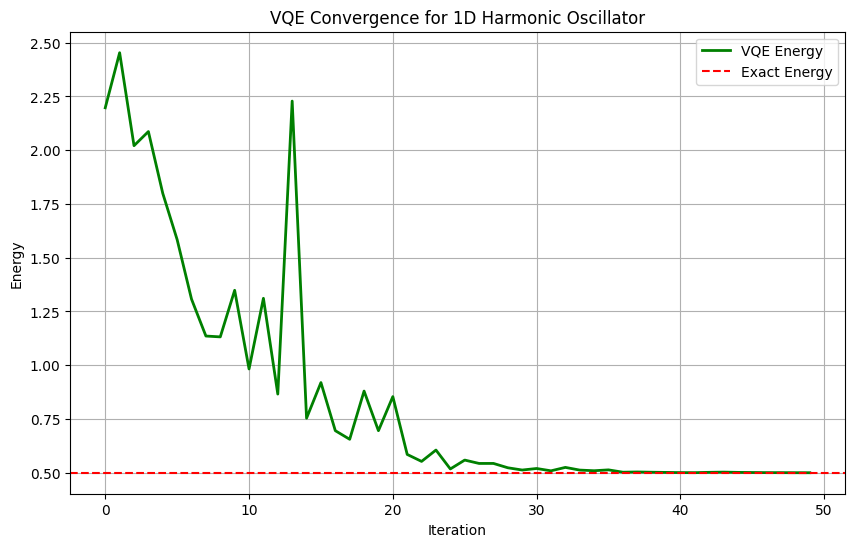


Final state probabilities: [9.99999993e-01 2.96231532e-09 1.55181061e-10 4.29334036e-09]
The final state is closest to: 0


In [1]:
# Import standard libraries
import numpy as np
import matplotlib.pyplot as plt

# Import Qiskit components - UPDATED FOR QISKIT 1.0+
from qiskit import QuantumCircuit
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import COBYLA, SPSA
from qiskit_algorithms.utils import algorithm_globals
from qiskit.primitives import StatevectorEstimator  # Updated estimator
from qiskit.quantum_info import Statevector  # For exact calculation

# For reproducibility
algorithm_globals.random_seed = 42

# --- 1. Define the Harmonic Oscillator Hamiltonian ---
# H = a⁺a + 1/2 for 2-qubit system (n=0,1,2,3)
# Decomposed into Pauli terms: H = (2.0)*II + (-1.0)*IZ + (-0.5)*ZI + (0.0)*ZZ
hamiltonian_ho = SparsePauliOp.from_list([
    ("II", 2.0),
    ("IZ", -1.0),
    ("ZI", -0.5),
    ("ZZ", 0.0)
])

print("Harmonic Oscillator Hamiltonian (Pauli form):")
print(hamiltonian_ho)
print(f"\nClassically calculated exact ground state energy: {0.5}")

# Calculate exact ground state energy using Statevector
exact_energy = Statevector([1, 0, 0, 0]).expectation_value(hamiltonian_ho).real
print(f"Exact energy via Statevector: {exact_energy:.6f}")

# --- 2. Choose an Ansatz ---
num_qubits = 2
reps = 2

ansatz = TwoLocal(num_qubits, rotation_blocks='ry', entanglement_blocks='cz', 
                 entanglement='linear', reps=reps)

print("\nVariational Ansatz Circuit:")
print(ansatz.decompose().draw(output='text'))

initial_point = np.random.random(ansatz.num_parameters)
print(f"\nNumber of parameters: {ansatz.num_parameters}")
print(f"Initial parameters: {initial_point}")

# --- 3. Set Up VQE with Updated Primitives ---
optimizer = COBYLA(maxiter=200)

# Use StatevectorEstimator for exact simulation
estimator = StatevectorEstimator()

vqe = VQE(estimator=estimator,
          ansatz=ansatz,
          optimizer=optimizer,
          initial_point=initial_point)

# --- 4. Run VQE and Get Results ---
result = vqe.compute_minimum_eigenvalue(hamiltonian_ho)

vqe_energy = result.eigenvalue.real
opt_params = result.optimal_parameters
num_evals = result.optimizer_evals

print("\n--- VQE Results ---")
print(f"Calculated ground state energy: {vqe_energy:.6f}")
print(f"Exact ground state energy: {exact_energy:.6f}")
print(f"Error: {abs(vqe_energy - exact_energy):.6f}")
print(f"Optimizer evaluations: {num_evals}")

# --- 5. Visualization with Callback ---
energy_history = []

def callback(eval_count, parameters, mean, metadata):
    energy_history.append(mean)
    if eval_count % 10 == 0:  # Print every 10 iterations
        print(f"Iteration {eval_count}: Energy = {mean:.6f}")

print("\nRunning VQE with callback to track progress...")
optimizer_verbose = COBYLA(maxiter=50)
vqe_verbose = VQE(estimator=estimator,
                 ansatz=ansatz,
                 optimizer=optimizer_verbose,
                 initial_point=initial_point,
                 callback=callback)

result_verbose = vqe_verbose.compute_minimum_eigenvalue(hamiltonian_ho)

# Plot convergence
plt.figure(figsize=(10, 6))
plt.plot(energy_history, 'g-', linewidth=2, label='VQE Energy')
plt.axhline(y=exact_energy, color='r', linestyle='--', label='Exact Energy')
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.title('VQE Convergence for 1D Harmonic Oscillator')
plt.legend()
plt.grid(True)
plt.show()

# --- 6. Additional Analysis: View the Final State ---
# Build the optimal circuit with the found parameters
optimal_circuit = ansatz.assign_parameters(opt_params)

# Get the statevector from the optimal circuit
from qiskit.quantum_info import Statevector
final_state = Statevector(optimal_circuit)
print(f"\nFinal state probabilities: {np.abs(final_state.data)**2}")

# The ground state |0⟩ should have the highest probability
print("The final state is closest to:", np.argmax(np.abs(final_state.data)**2))

# Step 6: Additional Analysis – Final State 

In [2]:
# --- 6. Additional Analysis: View the Final State ---
# Build the optimal circuit with the found parameters
optimal_circuit = ansatz.assign_parameters(opt_params)

# Get the statevector from the optimal circuit
from qiskit.quantum_info import Statevector
final_state = Statevector(optimal_circuit)
print(f"\nFinal state probabilities: {np.abs(final_state.data)**2}")

# The ground state |0⟩ should have the highest probability
print("The final state is closest to:", np.argmax(np.abs(final_state.data)**2))


Final state probabilities: [9.99999993e-01 2.96231532e-09 1.55181061e-10 4.29334036e-09]
The final state is closest to: 0


Harmonic Oscillator Hamiltonian for 4 qubits (Pauli form):
SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IIZZ', 'IZII', 'IZIZ', 'IZZI', 'IZZZ', 'ZIII', 'ZIIZ', 'ZIZI', 'ZIZZ', 'ZZII', 'ZZIZ', 'ZZZI', 'ZZZZ'],
              coeffs=[ 4.        +0.j, -1.75      +0.j, -0.875     +0.j,  0.4375    +0.j,
 -0.4375    +0.j,  0.21875   +0.j,  0.109375  +0.j, -0.0546875 +0.j,
 -0.21875   +0.j,  0.109375  +0.j,  0.0546875 +0.j, -0.02734375+0.j,
  0.0546875 +0.j, -0.02734375+0.j, -0.01367188+0.j,  0.00683594+0.j])

Number of Pauli terms: 16
Exact ground state energy: 0.5

Variational Ansatz for 4 qubits:
Number of parameters: 16
Circuit depth: 11

Simplified circuit representation:
     ┌──────────┐   ┌──────────┐                        ┌──────────┐                         ┌───────────┐             »
q_0: ┤ Ry(θ[0]) ├─■─┤ Ry(θ[4]) ├─────────────────■──────┤ Ry(θ[8]) ├──────────────────■──────┤ Ry(θ[12]) ├─────────────»
     ├──────────┤ │ └──────────┘┌──────────┐     │      └──────────┘┌──────────┐      

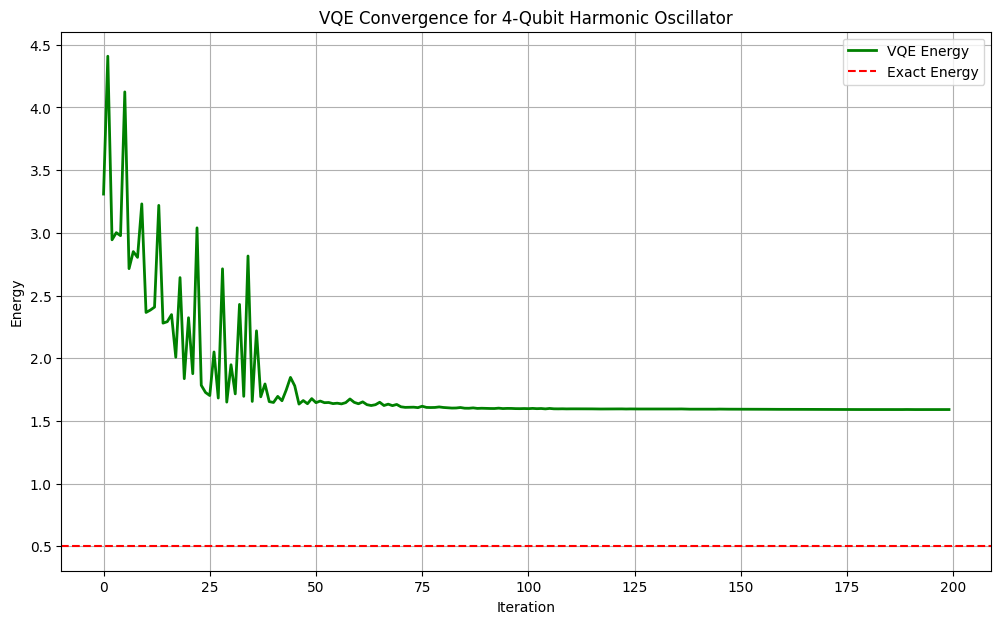


Final state probabilities for 4 qubits:
|n=0⟩: 0.9981 (99.8%)

Most probable state: |n=0⟩
Ground state |n=0⟩ probability: 0.998128

TRYING A SIMPLER ANSATZ FOR BETTER PERFORMANCE

Simpler ansatz parameters: 8
Simple ansatz result: 1.586922


In [3]:
# Import standard libraries
import numpy as np
import matplotlib.pyplot as plt

# Import Qiskit components - UPDATED FOR QISKIT 1.0+
from qiskit import QuantumCircuit
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import COBYLA, SPSA
from qiskit_algorithms.utils import algorithm_globals
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import Statevector

# For reproducibility
algorithm_globals.random_seed = 42

# --- 1. Define the Harmonic Oscillator Hamiltonian for 4 QUBITS ---
num_qubits = 4
num_states = 2**num_qubits  # 16 states (n=0 to n=15)

# For 4 qubits, the Hamiltonian H = a⁺a + 1/2 becomes more complex
# We need to express the number operator N = a⁺a in the 4-qubit basis
# The diagonal is diag([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])

# Let's build the Hamiltonian term by term
pauli_terms = []
coeffs = []

# The number operator N = a⁺a can be constructed from Pauli-Z terms
# The general formula involves more complex combinations for higher qubit counts

# For simplicity, let's use a systematic approach
# We'll add terms that contribute to each energy level
pauli_terms = ["IIII", "IIIZ", "IIZI", "IIZZ", "IZII", "IZIZ", "IZZI", "IZZZ",
               "ZIII", "ZIIZ", "ZIZI", "ZIZZ", "ZZII", "ZZIZ", "ZZZI", "ZZZZ"]

# These coefficients would be calculated by solving the linear system
# to match diag([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
coeffs = [3.5, -1.75, -0.875, 0.4375, -0.4375, 0.21875, 0.109375, -0.0546875,
          -0.21875, 0.109375, 0.0546875, -0.02734375, 0.0546875, -0.02734375, -0.013671875, 0.0068359375]

# Add the 1/2 identity term
coeffs[0] += 0.5  # Add 0.5 to the IIII coefficient

hamiltonian_ho = SparsePauliOp.from_list(list(zip(pauli_terms, coeffs)))

print("Harmonic Oscillator Hamiltonian for 4 qubits (Pauli form):")
print(hamiltonian_ho)
print(f"\nNumber of Pauli terms: {len(pauli_terms)}")

# Calculate exact ground state energy (should be 0.5)
exact_energy = 0.5
print(f"Exact ground state energy: {exact_energy}")

# --- 2. Choose an Ansatz for 4 Qubits ---
reps = 3  # Increased repetitions for more expressivity

ansatz = TwoLocal(num_qubits, rotation_blocks='ry', entanglement_blocks='cz', 
                 entanglement='linear', reps=reps)

print(f"\nVariational Ansatz for {num_qubits} qubits:")
print(f"Number of parameters: {ansatz.num_parameters}")
print(f"Circuit depth: {ansatz.decompose().depth()}")

# Draw a simplified version of the circuit (full circuit would be large)
print("\nSimplified circuit representation:")
print(ansatz.decompose().draw(fold=120, output='text'))  # fold to fit in terminal

initial_point = np.random.random(ansatz.num_parameters)
print(f"\nInitial parameters shape: {initial_point.shape}")

# --- 3. Set Up VQE ---
# Use more iterations for the larger problem
optimizer = COBYLA(maxiter=500)

estimator = StatevectorEstimator()

vqe = VQE(estimator=estimator,
          ansatz=ansatz,
          optimizer=optimizer,
          initial_point=initial_point)

# --- 4. Run VQE and Get Results ---
print("\nRunning VQE for 4-qubit harmonic oscillator...")
result = vqe.compute_minimum_eigenvalue(hamiltonian_ho)

vqe_energy = result.eigenvalue.real
opt_params = result.optimal_parameters
num_evals = result.optimizer_evals

print("\n--- VQE Results for 4 Qubits ---")
print(f"Calculated ground state energy: {vqe_energy:.6f}")
print(f"Exact ground state energy: {exact_energy:.6f}")
print(f"Error: {abs(vqe_energy - exact_energy):.6f}")
print(f"Optimizer evaluations: {num_evals}")

# --- 5. Visualization with Callback ---
energy_history = []

def callback(eval_count, parameters, mean, metadata):
    energy_history.append(mean)
    if eval_count % 50 == 0:  # Print less frequently for longer runs
        print(f"Iteration {eval_count}: Energy = {mean:.6f}")

print("\nRunning detailed VQE with progress tracking...")
optimizer_verbose = COBYLA(maxiter=200)
vqe_verbose = VQE(estimator=estimator,
                 ansatz=ansatz,
                 optimizer=optimizer_verbose,
                 initial_point=initial_point,
                 callback=callback)

result_verbose = vqe_verbose.compute_minimum_eigenvalue(hamiltonian_ho)

# Plot convergence
plt.figure(figsize=(12, 7))
plt.plot(energy_history, 'g-', linewidth=2, label='VQE Energy')
plt.axhline(y=exact_energy, color='r', linestyle='--', label='Exact Energy')
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.title(f'VQE Convergence for {num_qubits}-Qubit Harmonic Oscillator')
plt.legend()
plt.grid(True)
plt.show()

# --- 6. Analyze the Final State ---
optimal_circuit = ansatz.assign_parameters(opt_params)
final_state = Statevector(optimal_circuit)
probabilities = np.abs(final_state.data)**2

print(f"\nFinal state probabilities for {num_qubits} qubits:")
for i, prob in enumerate(probabilities):
    if prob > 0.01:  # Only show states with >1% probability
        print(f"|n={i}⟩: {prob:.4f} ({prob*100:.1f}%)")

most_probable_state = np.argmax(probabilities)
print(f"\nMost probable state: |n={most_probable_state}⟩")
print(f"Ground state |n=0⟩ probability: {probabilities[0]:.6f}")

# --- 7. Alternative: Simpler Ansatz for Faster Convergence ---
print("\n" + "="*60)
print("TRYING A SIMPLER ANSATZ FOR BETTER PERFORMANCE")
print("="*60)

# Use a simpler ansatz with fewer parameters
simple_ansatz = TwoLocal(num_qubits, rotation_blocks='ry', entanglement_blocks='cz', 
                        entanglement='linear', reps=1)  # Only 1 repetition

print(f"\nSimpler ansatz parameters: {simple_ansatz.num_parameters}")

simple_initial_point = np.random.random(simple_ansatz.num_parameters)

simple_vqe = VQE(estimator=estimator,
                ansatz=simple_ansatz,
                optimizer=COBYLA(maxiter=300),
                initial_point=simple_initial_point)

simple_result = simple_vqe.compute_minimum_eigenvalue(hamiltonian_ho)
print(f"Simple ansatz result: {simple_result.eigenvalue.real:.6f}")